 # Restaurant Review Classifiers

## Overview
This notebook demonstrates a multi-output classification model for restaurant reviews, predicting food, service, and atmosphere ratings.

In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

In [26]:
class RestaurantReviewClassifier:
    def __init__(self, model='logistic_regression'):
        self.tfidf_vectorizer = TfidfVectorizer(
            stop_words='english',
            max_features=5000,
            ngram_range=(1, 2)
        )
        self.label_encoders = {
            'food': LabelEncoder(),
            'service': LabelEncoder(),
            'atmosphere': LabelEncoder()
        }

        # Initialize classifier based on input model
        if model == 'logistic_regression':
            base_classifier = LogisticRegression(max_iter=1000)
        elif model == 'random_forest':
            base_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
        elif model == 'svm':
            base_classifier = SVC(probability=True, kernel='linear')
        else:
            raise ValueError("Model not supported. Choose from 'logistic_regression', 'random_forest', 'svm'.")

        self.classifier = MultiOutputClassifier(base_classifier)

    def preprocess_data(self, df):
        # Drop rows with NaN in text column
        df = df.dropna(subset=['text'])

        # Fill NaN in categorical columns with 'None'
        columns = ['food', 'service', 'atmosphere']
        for col in columns:
            if col not in df.columns:
                df[col] = 'None'
            df.loc[:, col] = df[col].fillna('None')

        return df

    def train(self, df):
        # Preprocess data
        df = self.preprocess_data(df)

        # Vectorize text
        X = self.tfidf_vectorizer.fit_transform(df['text'].astype(str))

        # Encode labels dynamically
        y_dict = {}
        for col in ['food', 'service', 'atmosphere']:
            unique_labels = df[col].unique()
            self.label_encoders[col].fit(unique_labels)
            y_dict[col] = self.label_encoders[col].transform(df[col])

        y = pd.DataFrame(y_dict)

        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42
        )

        # Train classifier
        self.classifier.fit(X_train, y_train)

        # Predict
        y_pred = self.classifier.predict(X_test)

        # Evaluate
        print("\nModel Performance Metrics:")
        for i, col in enumerate(['food', 'service', 'atmosphere']):
            print(f"\n{col.capitalize()} Classification:")
            classes = self.label_encoders[col].classes_

            accuracy = accuracy_score(y_test.iloc[:, i], y_pred[:, i])
            print(f"Accuracy: {accuracy:.2%}")

            print(classification_report(
                y_test.iloc[:, i],
                y_pred[:, i],
                labels=range(len(classes)),
                target_names=classes
            ))

    def predict(self, texts):
        # Convert texts to strings and handle potential NaN
        texts = [str(text) if pd.notna(text) else '' for text in texts]

        # Vectorize input
        X = self.tfidf_vectorizer.transform(texts)

        # Predict
        predictions = self.classifier.predict(X)

        # Decode predictions
        results = []
        for pred in predictions:
            result = {
                col: self.label_encoders[col].inverse_transform([p])[0]
                for col, p in zip(['food', 'service', 'atmosphere'], pred)
            }
            results.append(result)

        return results


In [27]:
# Logistic Regression
classifier_lr = RestaurantReviewClassifier(model='logistic_regression')

# Random Forest
classifier_rf = RestaurantReviewClassifier(model='random_forest')

# Support Vector Machine
classifier_svm = RestaurantReviewClassifier(model='svm')


### Preapare dataset with random sampled ganerated comments

In [28]:
clean_df = pd.read_csv("../raw_data/clean_data.csv")
clean_df['time'] = pd.to_datetime(clean_df['time'], unit='s')

generated_df = pd.read_csv("../raw_data/generated_data.csv")
generated_df['time'] = pd.to_datetime(generated_df['time'], unit='s')


def limit_data_to_positive(df):
    if 'to_be_removed' in df.columns:
        df = df[df['to_be_removed'].isna()]

    df_low_score = df[df['rating'] < 5]

    # Sample 500 reviews with a score of 5
    df_score_5_sample = df[df['rating'] == 5].sample(n=832, random_state=42)

    print(len(df_low_score))
    print(len(df_score_5_sample))
    df_filtered = pd.concat([df_low_score, df_score_5_sample])
    df_filtered.reset_index(drop=True, inplace=True)
    df = df_filtered
    df['time'] = pd.to_datetime(df['time'], unit='s')
    missing_data = df.isnull().sum()
    return df

clean_df = limit_data_to_positive(clean_df)
clean_df.to_csv('../raw_data/random_clean_data.csv', index=False)


def count_sentiments(df):
    results = []
    for column in ['food', 'service', 'atmosphere']:
        none_count = df[column].isna().sum()  # Liczba wartości None
        negative_count = (df[column] == 'Negative').sum()  # Liczba "Negative"
        positive_count = (df[column] == 'Positive').sum()  # Liczba "Positive"
        results.append([none_count, negative_count, positive_count])
    return results

def Equality_coefiecent(counts_matrix):
    total_sum = 0
    for lst in counts_matrix:
        max_diff = max(lst) - min(lst)
        sum_elements = sum(lst)
        total_sum += max_diff / sum_elements
    return total_sum

def reschape_df_choose_the_best(original_records, additional_records, iterations=20, max_percent_of_new_records = 25,
                                base_length_on_original_df = True):

    best_coef = float('inf')
    best_df = None
    if base_length_on_original_df:
        max_new_records_numbers = int( len(original_records)/100 * max_percent_of_new_records)
    else:
        max_new_records_numbers = int( len(additional_records)/100 * max_percent_of_new_records)

    for i in range(iterations):
        random_sample = additional_records.sample(n=max_new_records_numbers)
        df_combined = pd.concat([original_records, random_sample], axis=0)
        counts_matrix = count_sentiments(df_combined)
        coef = Equality_coefiecent(counts_matrix)
        if best_df is None or coef < best_coef:
            best_df = df_combined
            best_coef = coef

    return best_df

# df = reschape_df_choose_the_best(clean_df,generated_df,1,100,False)
df = reschape_df_choose_the_best(clean_df,generated_df)
df.to_csv('../raw_data/random_choice_data.csv', index=False)




832
832


C:\Users\Sebastian\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\tools\datetimes.py:558: RuntimeWarning: invalid value encountered in cast
  arr, tz_parsed = tslib.array_with_unit_to_datetime(arg, unit, errors=errors)


### Load Data

In [29]:
df = pd.read_csv('../raw_data/random_choice_data.csv')  # Load your dataset


### Train using Logistic Regression

In [30]:
# Train using Logistic Regression
classifier_lr.train(df)

C:\Users\SEBAST~1\AppData\Local\Temp/ipykernel_6620/1378635224.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, col] = df[col].fillna('None')



Model Performance Metrics:

Food Classification:
Accuracy: 80.05%
              precision    recall  f1-score   support

    Negative       0.71      0.57      0.63        98
        None       0.80      0.49      0.61        67
    Positive       0.82      0.97      0.89       251

    accuracy                           0.80       416
   macro avg       0.78      0.68      0.71       416
weighted avg       0.79      0.80      0.79       416


Service Classification:
Accuracy: 74.52%
              precision    recall  f1-score   support

    Negative       0.82      0.60      0.69        90
        None       0.72      0.77      0.74       158
    Positive       0.74      0.80      0.77       168

    accuracy                           0.75       416
   macro avg       0.76      0.72      0.74       416
weighted avg       0.75      0.75      0.74       416


Atmosphere Classification:
Accuracy: 75.00%
              precision    recall  f1-score   support

    Negative       0.89      

### Train using Random Forest

In [31]:
classifier_rf.train(df)

C:\Users\SEBAST~1\AppData\Local\Temp/ipykernel_6620/1378635224.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, col] = df[col].fillna('None')



Model Performance Metrics:

Food Classification:
Accuracy: 79.09%
              precision    recall  f1-score   support

    Negative       0.82      0.42      0.55        98
        None       0.77      0.64      0.70        67
    Positive       0.79      0.98      0.87       251

    accuracy                           0.79       416
   macro avg       0.79      0.68      0.71       416
weighted avg       0.79      0.79      0.77       416


Service Classification:
Accuracy: 75.24%
              precision    recall  f1-score   support

    Negative       0.90      0.52      0.66        90
        None       0.72      0.83      0.77       158
    Positive       0.74      0.80      0.77       168

    accuracy                           0.75       416
   macro avg       0.79      0.72      0.73       416
weighted avg       0.77      0.75      0.75       416


Atmosphere Classification:
Accuracy: 75.24%
              precision    recall  f1-score   support

    Negative       0.86      

### Train using SVM

In [32]:
classifier_svm.train(df)




C:\Users\SEBAST~1\AppData\Local\Temp/ipykernel_6620/1378635224.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, col] = df[col].fillna('None')



Model Performance Metrics:

Food Classification:
Accuracy: 79.09%
              precision    recall  f1-score   support

    Negative       0.65      0.63      0.64        98
        None       0.76      0.51      0.61        67
    Positive       0.85      0.93      0.89       251

    accuracy                           0.79       416
   macro avg       0.75      0.69      0.71       416
weighted avg       0.79      0.79      0.78       416


Service Classification:
Accuracy: 75.24%
              precision    recall  f1-score   support

    Negative       0.74      0.69      0.71        90
        None       0.73      0.77      0.75       158
    Positive       0.78      0.77      0.77       168

    accuracy                           0.75       416
   macro avg       0.75      0.74      0.75       416
weighted avg       0.75      0.75      0.75       416


Atmosphere Classification:
Accuracy: 78.12%
              precision    recall  f1-score   support

    Negative       0.89      

### Predict using Logistic Regression



In [33]:
# load test_data_reviews
test_data = pd.read_csv('../test_data_reviews/2_4_review.csv')    

# Predict using Logistic Regression
predictions_lr = classifier_lr.predict(test_data['text'][0:5])
#print review text and predicted ratings
for i in range(5):
    print(test_data['wiI7pd'][i])
    print("Logistic Regression Predictions:", predictions_lr[i])
    print("\n")

Żenada ulotki zostawione w pensjonacie ale można sobie do nich dzwonić. Po kilkunastu wykonanych połączeniach i braku odzewu, udaliśmy się tam osobiście bo mieliśmy 750m. Po dotarciu na miejsce dodam że to była niedziela lokal Restro &…
Logistic Regression Predictions: {'food': 'None', 'service': 'None', 'atmosphere': 'None'}


Jedzenie okropne kebab się rozlatuje. Zamawiasz kebaba i dostajesz i tak tego z menu wszystko wygląda okropnie. Obsługa niemiła i wredna. Czas oczekiwania również długi.
Logistic Regression Predictions: {'food': 'Negative', 'service': 'Negative', 'atmosphere': 'None'}


Dostałem kebab, który został zamówiony na wskazany adres.  Kebab to jedna wielka porażka tłuszczowa.  Nie polecam nikomu, pizza przykleiła się do tektury z opakowania.
Logistic Regression Predictions: {'food': 'Positive', 'service': 'None', 'atmosphere': 'None'}


Jeśli jesteś miłośnikiem dobrych zartów, to ta pizzeria to jest właśnie to. Boczek przykleja się do pudełka niczym cygan do zasiłku. S

### Predict using Random Forest

In [34]:
# Predict using Random Forest
predictions_rf = classifier_rf.predict(test_data['text'][0:5])
#print review text and predicted ratings
for i in range(5):
    print(test_data['wiI7pd'][i])
    print("Random Forest Predictions:", predictions_rf[i])
    print("\n")

Żenada ulotki zostawione w pensjonacie ale można sobie do nich dzwonić. Po kilkunastu wykonanych połączeniach i braku odzewu, udaliśmy się tam osobiście bo mieliśmy 750m. Po dotarciu na miejsce dodam że to była niedziela lokal Restro &…
Random Forest Predictions: {'food': 'None', 'service': 'None', 'atmosphere': 'Positive'}


Jedzenie okropne kebab się rozlatuje. Zamawiasz kebaba i dostajesz i tak tego z menu wszystko wygląda okropnie. Obsługa niemiła i wredna. Czas oczekiwania również długi.
Random Forest Predictions: {'food': 'Positive', 'service': 'Negative', 'atmosphere': 'None'}


Dostałem kebab, który został zamówiony na wskazany adres.  Kebab to jedna wielka porażka tłuszczowa.  Nie polecam nikomu, pizza przykleiła się do tektury z opakowania.
Random Forest Predictions: {'food': 'Positive', 'service': 'None', 'atmosphere': 'None'}


Jeśli jesteś miłośnikiem dobrych zartów, to ta pizzeria to jest właśnie to. Boczek przykleja się do pudełka niczym cygan do zasiłku. Szynka konserwo

### Predict using SVM

In [35]:
# Predict using SVM
predictions_svm = classifier_svm.predict(test_data['text'][0:5])
#print review text and predicted ratings
for i in range(5):
    print(test_data['wiI7pd'][i])
    print("SVM Predictions:", predictions_svm[i])
    print("\n")

Żenada ulotki zostawione w pensjonacie ale można sobie do nich dzwonić. Po kilkunastu wykonanych połączeniach i braku odzewu, udaliśmy się tam osobiście bo mieliśmy 750m. Po dotarciu na miejsce dodam że to była niedziela lokal Restro &…
SVM Predictions: {'food': 'None', 'service': 'Negative', 'atmosphere': 'None'}


Jedzenie okropne kebab się rozlatuje. Zamawiasz kebaba i dostajesz i tak tego z menu wszystko wygląda okropnie. Obsługa niemiła i wredna. Czas oczekiwania również długi.
SVM Predictions: {'food': 'Negative', 'service': 'Negative', 'atmosphere': 'None'}


Dostałem kebab, który został zamówiony na wskazany adres.  Kebab to jedna wielka porażka tłuszczowa.  Nie polecam nikomu, pizza przykleiła się do tektury z opakowania.
SVM Predictions: {'food': 'Positive', 'service': 'None', 'atmosphere': 'None'}


Jeśli jesteś miłośnikiem dobrych zartów, to ta pizzeria to jest właśnie to. Boczek przykleja się do pudełka niczym cygan do zasiłku. Szynka konserwowa złapana na promocji pięknie

### Confiusion matrix

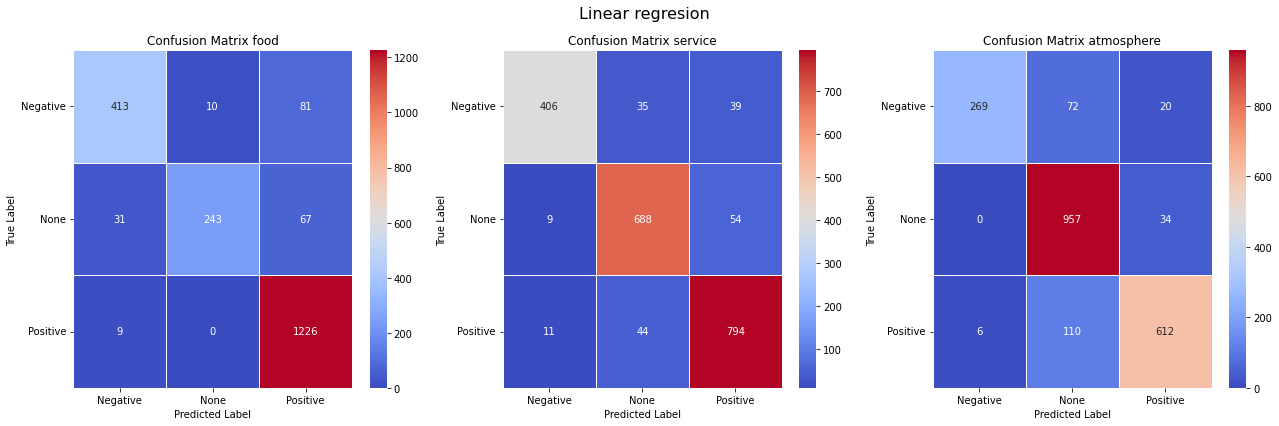

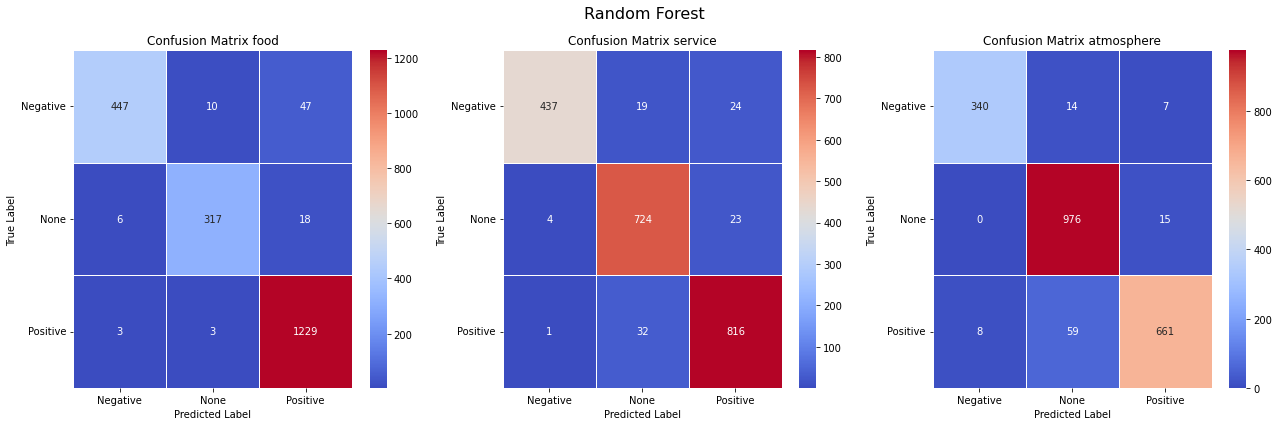

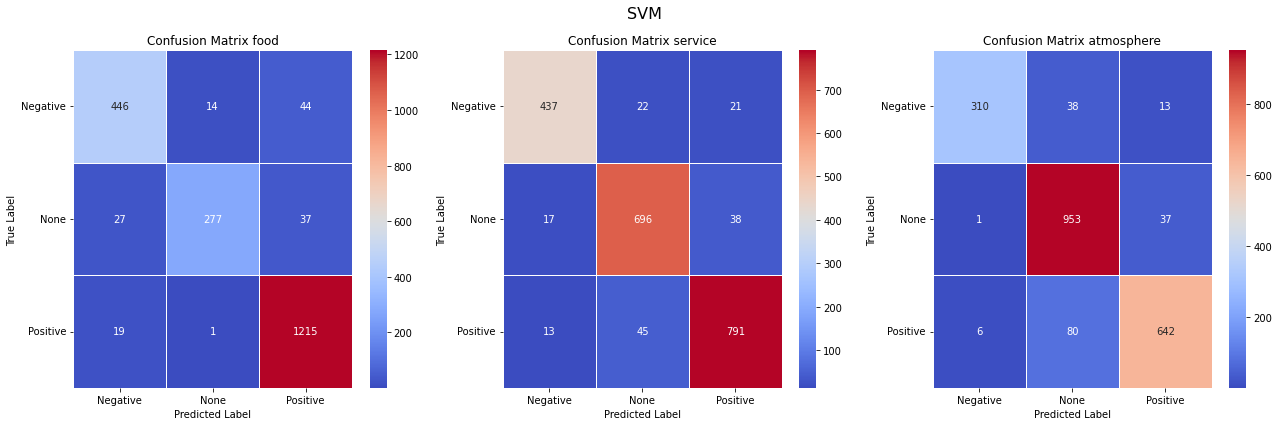

In [36]:
def show_confusion_matrices(matrices, classifier_name, labels=None, categories_names = ["food","service","atmosphere"]):
    num_matrices = len(matrices)
    fig, axes = plt.subplots(1, num_matrices, figsize=(6 * num_matrices, 6))

    for i, matrix in enumerate(matrices):
        ax = axes[i] if num_matrices > 1 else axes
        num_classes = matrix.shape[0]

        if labels is None:
            labels = [str(j) for j in range(num_classes)]

        sns.heatmap(matrix,
                    cmap='coolwarm',
                    linecolor='white',
                    linewidths=1,
                    xticklabels=labels[0:num_classes],
                    yticklabels=labels[0:num_classes],
                    annot=True,
                    fmt='d',
                    ax=ax)

        ax.set_title(f'Confusion Matrix {categories_names[i]}')
        ax.set_ylabel('True Label')
        ax.set_xlabel('Predicted Label')
        ax.yaxis.set_tick_params(rotation=0)
    fig.suptitle(f"{classifier_name}", fontsize=16)
    plt.tight_layout()
    plt.show()


def compute_and_show_confusion_matrix(validations, predictions, classifier_name):
    matrices = [metrics.confusion_matrix(validations[i], predictions[i]) for i in range(len(validations))]
    show_confusion_matrices(matrices,classifier_name, labels = ["Negative","None","Positive"])


food_validation =  df['food'].fillna('None').tolist()
service_validation = df['service'].fillna('None').tolist()
atmosphere_validation = df['atmosphere'].fillna('None').tolist()


def create_predicions_to_list(classifier):
    predictions = classifier.predict(df['text'])
    preditions_food = [pred["food"] for pred in predictions]
    preditions_service = [pred["service"] for pred in predictions]
    preditions_atmosphere = [pred["atmosphere"] for pred in predictions]
    return preditions_food, preditions_service, preditions_atmosphere

labels_to_classificators = ["Linear regresion", "Random Forest", "SVM"]
classi_list = [classifier_lr,classifier_rf,classifier_svm]
for i in range(3):
    pred= create_predicions_to_list(classi_list[i])
    validation = [food_validation,service_validation,atmosphere_validation]
    compute_and_show_confusion_matrix(validation,pred,  labels_to_classificators[i])




### Rating Function

In [37]:
def adjusted_weight(none, positive, negative):
    total = positive + negative
    if none > total:
        factor = (total / none) *(-2)  if none > -2 else -2
        return factor
    return 0

def Final_Rating(reviews_path,classifier):
    test_data = pd.read_csv(reviews_path)

    predictions = classifier.predict(test_data['text'])

    total_amount_of_predicions = len(predictions)
    Ratings = \
        {
            "food":{
                'None':0 ,'Positive':0,'Negative':0
            },
            "service":{
                'None':0 ,'Positive':0,'Negative':0
            },
            "atmosphere":{
                'None':0 ,'Positive':0,'Negative':0
            }
        }
    # print(Ratings)

    for i in predictions:
        for aspect in ["food","service","atmosphere"]:
            Ratings[aspect][i[aspect]] += 1

    for aspect in Ratings:
        for rate in Ratings[aspect]:
            Ratings[aspect][rate] =  round(Ratings[aspect][rate]/total_amount_of_predicions*100,2)

    food_weight = adjusted_weight(Ratings["food"]['None'], Ratings["food"]['Positive'], Ratings["food"]['Negative'])
    service_weight = adjusted_weight(Ratings["service"]['None'], Ratings["service"]['Positive'], Ratings["service"]['Negative'])
    atmosphere_weight = adjusted_weight(Ratings["atmosphere"]['None'], Ratings["atmosphere"]['Positive'], Ratings["atmosphere"]['Negative'])

    # weight_sum = food_weight + service_weight + atmosphere_weight
    # food_weight /= weight_sum
    # service_weight /= weight_sum
    # atmosphere_weight /= weight_sum

    print(food_weight,service_weight, atmosphere_weight)

    wages = {'None':0 ,'Positive':5 ,'Negative':-5}

    print(Ratings)

    a = 4 / (wages['Positive'] - wages['Negative'])

    b = 5 - a * wages['Positive']

    food_final_score = (Ratings["food"]['None'] * food_weight +
                        Ratings["food"]['Positive'] * wages['Positive'] +
                        Ratings["food"]['Negative']  * wages['Negative'])/100 *a +b
    service_final_score = (Ratings["service"]['None'] *service_weight +
                           Ratings["service"]['Positive'] * wages['Positive']
                           + Ratings["service"]['Negative'] * wages['Negative'])/100 *a +b
    atmosphere_final_score = (Ratings["atmosphere"]['None'] * atmosphere_weight +
                              Ratings["atmosphere"]['Positive'] * wages['Positive']
                              + Ratings["atmosphere"]['Negative'] * wages['Negative'])/100 *a +b




    return food_final_score,service_final_score,atmosphere_final_score,round((food_final_score+service_final_score+atmosphere_final_score)/3,1)


files = ['../test_data_reviews/2_4_review.csv',
         '../test_data_reviews/2_9_review.csv',
         '../test_data_reviews/3_4_review.csv',
         '../test_data_reviews/4_7_review.csv']

classifiers = {'Logistic Regression': classifier_lr,
               'Random Forest': classifier_rf,
               'SVM': classifier_svm}
results = []

for file in files:
    file_name = file.split('/')[-1]
    for name, clf in classifiers.items():
        rating = Final_Rating(file, clf)
        results.append({'File': file_name, 'Classifier': name, 'Food_Rating': rating[0], 'Service_Rating': rating[1],
                        'Atmosphere_Rating': rating[2], 'Averge_Rating': rating[3]})

results_df = pd.DataFrame(results)

print(results_df)

0 -1.472825143254037 -0.051913409254129475
{'food': {'None': 0.63, 'Positive': 56.33, 'Negative': 43.04}, 'service': {'None': 57.59, 'Positive': 15.19, 'Negative': 27.22}, 'atmosphere': {'None': 97.47, 'Positive': 2.53, 'Negative': 0.0}}
0 -1.0385900941962931 -0.06526228831061544
{'food': {'None': 8.23, 'Positive': 74.68, 'Negative': 17.09}, 'service': {'None': 65.82, 'Positive': 16.46, 'Negative': 17.72}, 'atmosphere': {'None': 96.84, 'Positive': 2.53, 'Negative': 0.63}}
0 -1.5906642728904845 -0.06526228831061545
{'food': {'None': 3.8, 'Positive': 43.67, 'Negative': 52.53}, 'service': {'None': 55.7, 'Positive': 15.19, 'Negative': 29.11}, 'atmosphere': {'None': 96.84, 'Positive': 3.16, 'Negative': 0.0}}
0 0 -0.4218939210462581
{'food': {'None': 2.58, 'Positive': 64.84, 'Negative': 32.58}, 'service': {'None': 44.84, 'Positive': 29.03, 'Negative': 26.13}, 'atmosphere': {'None': 82.58, 'Positive': 16.45, 'Negative': 0.97}}
0 0 -0.3485204321277595
{'food': {'None': 7.1, 'Positive': 75.16, 